# Logistic Regression on BRCA subset of the TCGA dataset
#### Using Logistic Regression for breast cancer subtype classification

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt

## Load and split the dataset

In [4]:
# Training set
X_train = pd.read_pickle("../data/ciriello_brca_filtered_train.pkl")
X_train = X_train[X_train.Ciriello_subtype != "Normal"]
y_train = X_train["Ciriello_subtype"]


X_train.drop(['Ciriello_subtype'], axis="columns", inplace=True)

# Final test set
X_test = pd.read_pickle("../data/tcga_brca_filtered_test.pkl")
X_test = X_test[X_test.subtype != "Normal"]
y_test = X_test["subtype"]

X_test.drop(['subtype'], axis="columns", inplace=True)

# Order the features correctly

X_train = X_train.reindex(sorted(X_train.columns), axis="columns")
X_test = X_test.reindex(sorted(X_test.columns), axis="columns")

### Scale the data

In [5]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Code to tune parameter C

In [6]:
values=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
i=1
results = pd.DataFrame(columns=["Index", "C", "Accuracy"])
mean_scores = []

skf = StratifiedKFold(n_splits=5)
for c in values:
    scores = []

    for train_index, test_index in skf.split(X_train_scaled, y_train):

        X_cv_train, X_cv_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
        y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[test_index]

        clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=c, multi_class="auto").fit(X_cv_train, y_cv_train)

        score = clf.score(X_cv_val, y_cv_val)
        results = results.append({'Fold': i, 'C' : c , 'Score' : score}, ignore_index=True)
        scores.append(score)
        i+=1

    i=1
    mean_scores.append(np.mean(scores))
    print('Results: {}'.format(scores))
    print('C: {}, Accuracy: {}'.format(c, np.mean(scores)))

#results.to_csv("parameter_tuning/LogisticRegression/tcga_c_tuning_all_genes.csv", index=False)
mean_scores

Results: [0.175, 0.17088607594936708, 0.17088607594936708, 0.17088607594936708, 0.17088607594936708]
C: 0.001, Accuracy: 0.17170886075949368
Results: [0.51875, 0.5316455696202531, 0.5253164556962026, 0.5253164556962026, 0.5253164556962026]
C: 0.01, Accuracy: 0.5252689873417722
Results: [0.80625, 0.7784810126582279, 0.8734177215189873, 0.8670886075949367, 0.8291139240506329]
C: 0.1, Accuracy: 0.8308702531645571
Results: [0.85625, 0.8607594936708861, 0.8987341772151899, 0.9240506329113924, 0.8860759493670886]
C: 1, Accuracy: 0.8851740506329113
Results: [0.86875, 0.8987341772151899, 0.8924050632911392, 0.9177215189873418, 0.8860759493670886]
C: 10, Accuracy: 0.8927373417721519
Results: [0.88125, 0.8670886075949367, 0.9050632911392406, 0.8987341772151899, 0.8924050632911392]
C: 100, Accuracy: 0.8889082278481013
Results: [0.8625, 0.8670886075949367, 0.9113924050632911, 0.9050632911392406, 0.8860759493670886]
C: 1000, Accuracy: 0.8864240506329114
Results: [0.83125, 0.8354430379746836, 0.9113

[0.17170886075949368,
 0.5252689873417722,
 0.8308702531645571,
 0.8851740506329113,
 0.8927373417721519,
 0.8889082278481013,
 0.8864240506329114,
 0.8738449367088608]

### We can see that C=10 is the best parameter, hence why we'll use it to test our model

In [7]:
clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=10, multi_class="auto").fit(X_train_scaled, y_train)

In [8]:
final_score = clf.score(X_test_scaled, y_test)
print('Confusion matrix\n', confusion_matrix(y_test, clf.predict(X_test_scaled)))
print('Accuracy', final_score)

Confusion matrix
 [[ 42   0   1   0]
 [  0  11   1   4]
 [  0   1 119  11]
 [  0   0   3  29]]
Accuracy 0.9054054054054054


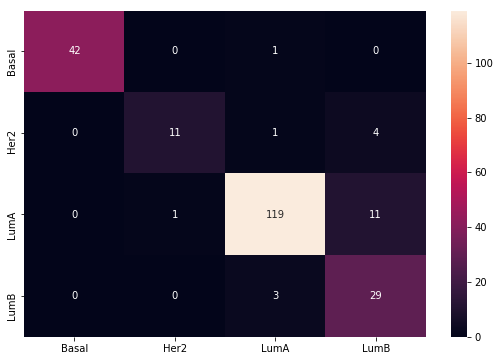

In [7]:
import matplotlib.pyplot as plt
conf_matrix = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test_scaled)))
plt.figure(figsize=(9, 6))
sn.heatmap(conf_matrix, annot=True, fmt='g')
conf_matrix.to_csv("results/LogisticRegression/tcga_confusion_matrix_all_genes.csv")

# Let's try to use the 5k more "influential"

## With mutual_info_classif

In [8]:
selector = SelectKBest(mutual_info_classif, k=5000).fit(X_train_scaled, y_train)
relevant_idx = selector.get_support()
relevant_genes = X_train_scaled.columns[relevant_idx]

### Load and split the dataset

In [9]:
X_train_relevant = X_train_scaled[relevant_genes]
X_test_relevant = X_test_scaled[relevant_genes]

### Tune parameter C

In [10]:
values=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
i=1
results = pd.DataFrame(columns=["Index", "C", "Accuracy"])
mean_scores = []

skf = StratifiedKFold(n_splits=5)

for c in values:
    scores = []
    
    for train_index, test_index in skf.split(X_train_relevant, y_train):

        X_cv_train, X_cv_val = X_train_relevant.iloc[train_index], X_train_relevant.iloc[test_index]
        y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[test_index]

        clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=c, multi_class="auto").fit(X_cv_train, y_cv_train)
        
        score = clf.score(X_cv_val, y_cv_val)
        results = results.append({'Fold': i, 'C' : c , 'Score' : score}, ignore_index=True)
        scores.append(score)
        i+=1
        
    i=1
    mean_scores.append(np.mean(scores))
    print('5-Fold results: {}'.format(scores))
    print('C: {}, Accuracy: {}'.format(c, np.mean(scores)))
        
results.to_csv("parameter_tuning/LogisticRegression/tcga_c_tuning_5k_mutual_info.csv", index=False)
mean_scores

5-Fold results: [0.175, 0.17088607594936708, 0.17088607594936708, 0.17088607594936708, 0.17088607594936708]
C: 0.001, Accuracy: 0.17170886075949368
5-Fold results: [0.51875, 0.5316455696202531, 0.5253164556962026, 0.5253164556962026, 0.5253164556962026]
C: 0.01, Accuracy: 0.5252689873417722
5-Fold results: [0.78125, 0.7911392405063291, 0.879746835443038, 0.8607594936708861, 0.8291139240506329]
C: 0.1, Accuracy: 0.8284018987341772
5-Fold results: [0.85625, 0.8734177215189873, 0.9050632911392406, 0.9177215189873418, 0.8924050632911392]
C: 1, Accuracy: 0.8889715189873417
5-Fold results: [0.8625, 0.8734177215189873, 0.9050632911392406, 0.930379746835443, 0.8987341772151899]
C: 10, Accuracy: 0.8940189873417722
5-Fold results: [0.89375, 0.879746835443038, 0.9240506329113924, 0.9367088607594937, 0.8987341772151899]
C: 100, Accuracy: 0.9065981012658229
5-Fold results: [0.90625, 0.879746835443038, 0.9240506329113924, 0.930379746835443, 0.8924050632911392]
C: 1000, Accuracy: 0.9065664556962025
5

[0.17170886075949368,
 0.5252689873417722,
 0.8284018987341772,
 0.8889715189873417,
 0.8940189873417722,
 0.9065981012658229,
 0.9065664556962025,
 0.900237341772152]

### Train the Model (best c=100)

In [11]:
clf_5k_mutual = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=100, multi_class="auto").fit(X_train_relevant, y_train)

In [12]:
final_score = clf_5k_mutual.score(X_test_relevant, y_test)
print('Confusion matrix\n', confusion_matrix(y_test, clf_5k_mutual.predict(X_test_relevant)))
print('Accuracy', final_score)

Confusion matrix
 [[ 43   0   0   0]
 [  0  14   1   1]
 [  0   0 123   8]
 [  0   0   6  26]]
Accuracy 0.9279279279279279


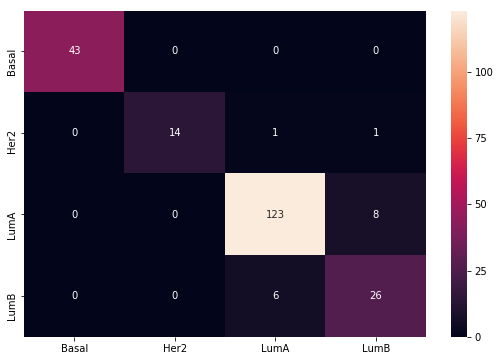

In [13]:
#How do I know the order of the labels???
import matplotlib.pyplot as plt
conf_matrix = pd.DataFrame(confusion_matrix(y_test, clf_5k_mutual.predict(X_test_relevant)), index = ["Basal", "Her2", "LumA", "LumB"], columns = ["Basal", "Her2", "LumA", "LumB"])
plt.figure(figsize=(9, 6))
sn.heatmap(conf_matrix, annot=True, fmt='g')
conf_matrix.to_csv("results/LogisticRegression/tcga_confusion_matrix_5k_mutual_info.csv")

## With chi2

In [14]:
selector = SelectKBest(chi2, k=5000).fit(X_train_scaled, y_train)
relevant_idx = selector.get_support()
relevant_genes = X_train_scaled.columns[relevant_idx]

In [15]:
X_train_relevant = X_train_scaled[relevant_genes]
X_test_relevant = X_test_scaled[relevant_genes]

### Tune parameter C

In [16]:
values=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
i=1
results = pd.DataFrame(columns=["Index", "C", "Accuracy"])
mean_scores = []

skf = StratifiedKFold(n_splits=5)

for c in values:
    scores = []
    
    for train_index, test_index in skf.split(X_train_relevant, y_train):

        X_cv_train, X_cv_val = X_train_relevant.iloc[train_index], X_train_relevant.iloc[test_index]
        y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[test_index]

        clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=c, multi_class="auto").fit(X_cv_train, y_cv_train)
        
        score = clf.score(X_cv_val, y_cv_val)
        results = results.append({'Fold': i, 'C' : c , 'Score' : score}, ignore_index=True)
        scores.append(score)
        i+=1
        
    i=1
    mean_scores.append(np.mean(scores))
    print('5-Fold results: {}'.format(scores))
    print('C: {}, Accuracy: {}'.format(c, np.mean(scores)))
        
results.to_csv("parameter_tuning/LogisticRegression/tcga_c_tuning_5k_chi2.csv", index=False)
mean_scores

5-Fold results: [0.175, 0.17088607594936708, 0.17088607594936708, 0.17088607594936708, 0.17088607594936708]
C: 0.001, Accuracy: 0.17170886075949368
5-Fold results: [0.51875, 0.5316455696202531, 0.5253164556962026, 0.5253164556962026, 0.5253164556962026]
C: 0.01, Accuracy: 0.5252689873417722
5-Fold results: [0.78125, 0.7784810126582279, 0.879746835443038, 0.8607594936708861, 0.8354430379746836]
C: 0.1, Accuracy: 0.8271360759493671
5-Fold results: [0.8625, 0.8670886075949367, 0.8987341772151899, 0.9493670886075949, 0.8924050632911392]
C: 1, Accuracy: 0.8940189873417722
5-Fold results: [0.86875, 0.8670886075949367, 0.9050632911392406, 0.9367088607594937, 0.879746835443038]
C: 10, Accuracy: 0.8914715189873418
5-Fold results: [0.88125, 0.8860759493670886, 0.8987341772151899, 0.9177215189873418, 0.879746835443038]
C: 100, Accuracy: 0.8927056962025317
5-Fold results: [0.85, 0.8734177215189873, 0.9050632911392406, 0.9050632911392406, 0.8924050632911392]
C: 1000, Accuracy: 0.8851898734177215
5-

[0.17170886075949368,
 0.5252689873417722,
 0.8271360759493671,
 0.8940189873417722,
 0.8914715189873418,
 0.8927056962025317,
 0.8851898734177215,
 0.8725949367088607]

In [17]:
clf_5k_chi2 = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=100, multi_class="auto").fit(X_train_relevant, y_train)

In [18]:
final_score = clf_5k_chi2.score(X_test_relevant, y_test)
print('Confusion matrix\n', confusion_matrix(y_test, clf_5k_chi2.predict(X_test_relevant)))
print('Accuracy', final_score)

Confusion matrix
 [[ 43   0   0   0]
 [  0  12   1   3]
 [  0   1 124   6]
 [  0   0   7  25]]
Accuracy 0.918918918918919


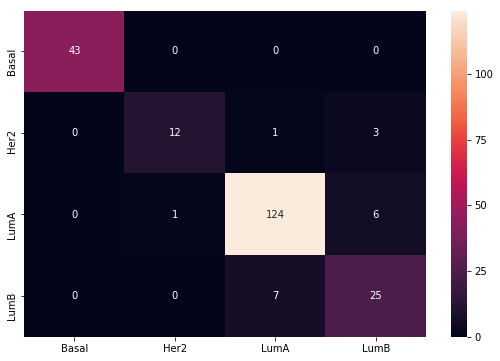

In [19]:
#How do I know the order of the labels???
import matplotlib.pyplot as plt
conf_matrix = pd.DataFrame(confusion_matrix(y_test, clf_5k_chi2.predict(X_test_relevant)), index = ["Basal", "Her2", "LumA", "LumB"], columns = ["Basal", "Her2", "LumA", "LumB"])
plt.figure(figsize=(9, 6))
sn.heatmap(conf_matrix, annot=True, fmt='g')
conf_matrix.to_csv("results/LogisticRegression/tcga_confusion_matrix_5k_chi2.csv")